# **PROJECT** #
## ***STOCK PRICE TIMELINE FORECASTING*** ##

### **Company Name: INFOSYS** ###

In [121]:

# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import pickle

### **Importing data from file infosys.csv** ###

**We have extracted the stock prices for INFOSYS from the website https://finance.yahoo.com/**
Steps are as follows -

    1. Visited the website https://finance.yahoo.com/
    2. Select the INFOSYS Stocks by searching in the search bar for "INFOSYS" and the BSE index.
    3. The data shows up as "Infosys Limited (INFY.BO)".
        In order to get the historical data for stock prices for INFOSYS, we need to select the "Historical Data" tab.
    4. We need to now select the "Time Period", with the Frequency as "Daily". We can click on the start "Time Period" and click "Max". It gives the maximum Time Period for stock prices.
    5. Click on the Apply button. This will give the Daily stock prices for the given maximum duration, in this case "Jan 03, 2000 - Nov 28, 2023".
    6. Click on the Download button. This will give us the option to download the file in a location in the computer.
        We have selected to download as a .csv file with the name as "infosys.csv"

In [122]:
# Importing the data from the file 'infosys.csv'
stock_orig_data = pd.read_csv('infosys.csv')
stock_orig_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2000,117.273438,122.480469,117.273438,122.480469,-2.162692,3804416.0
1,04-01-2000,132.278519,132.278519,125.000000,132.110931,-2.332741,12100608.0
2,05-01-2000,131.257813,131.257813,121.542191,121.542191,-2.146124,15264256.0
3,06-01-2000,119.531250,120.312500,111.819138,111.819138,-1.974440,9052800.0
4,07-01-2000,102.875000,102.875000,102.873825,102.873825,-1.816489,696832.0
...,...,...,...,...,...,...,...
5981,04-12-2023,1460.000000,1471.449951,1449.349976,1464.449951,1464.449951,123075.0
5982,05-12-2023,1464.349976,1466.949951,1442.199951,1453.699951,1453.699951,326852.0
5983,06-12-2023,1454.050049,1477.000000,1451.199951,1474.099976,1474.099976,167359.0
5984,07-12-2023,1474.099976,1474.099976,1462.000000,1466.150024,1466.150024,94902.0


Importing the file "infosys.csv" and reading it via the pandas read_csv module.</br>
**This gives us the columns - Date, Open, High, Low, Close, Adj Close and Volume.**</br>
We are interested in the "Date" and "Close" columns, so we will remove the remaining columns as part of the EDA steps.

### **EDA (Exploratory Data Analysis)** ###

In [123]:
# Getting the shape of the Data Frame, it shows us that we have 5972 rows and 7 columns
stock_orig_data.shape

(5986, 7)

#### *Descriptive Analysis* ####

In [124]:
# The .describe function help us get the Descriptive Analysis of the DataFrame.
# It give us the Count, Mean, Standard Deviation, Minimum, 25% Quartile, 50% Quartile or Median, 75% Quartile and the Maximum Value for each of the columns.
stock_orig_data.describe() # Describes the entire dataset

,Open,High,Low,Close,Adj Close,Volume
count,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5.936000e+03
mean,475.422240,480.461615,470.125391,475.217215,386.506996,5.386078e+06
std,446.288795,450.308704,442.179475,446.210878,475.160964,1.052657e+07
min,34.340626,34.340626,34.340626,34.340626,-7.086354,0.000000e+00
25%,151.968750,154.379692,148.768745,152.185940,37.004288,3.530758e+05
50%,343.237503,346.437500,340.321869,343.324997,185.346932,8.791920e+05
75%,580.000000,585.925018,571.690613,579.381256,528.692337,4.053274e+06
max,1935.000000,1953.699951,1931.150024,1939.349976,1889.180664,1.409381e+08


In [125]:
# If we want to get the Descriptive Analysis data for only the specific column/feature "Close", 
# we can run the command specific to that column as shown below
stock_orig_data['Close'].describe() # describe for the required column/feature 'Close'

count    5936.000000
mean      475.217215
std       446.210878
min        34.340626
25%       152.185940
50%       343.324997
75%       579.381256
max      1939.349976
Name: Close, dtype: float64

In [126]:
# We get the details of the number of null/non-null values and Data time for each column/feature.
stock_orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5986 non-null   object 
 1   Open       5936 non-null   float64
 2   High       5936 non-null   float64
 3   Low        5936 non-null   float64
 4   Close      5936 non-null   float64
 5   Adj Close  5936 non-null   float64
 6   Volume     5936 non-null   float64
dtypes: float64(6), object(1)
memory usage: 327.5+ KB


*Creating backup file*

In [127]:
# Creating a file 'stock_data' as copy of the original file 'stock_orig_data'
# We will do all the changes in this file only.

stock_data = stock_orig_data.copy()

#### *Dropping columns not needed* ####

In [128]:
# Once we have created a backup for the original file, we can now do changes on the file copy "stock_data"
# We are retraining only the desired 
stock_data = stock_orig_data[['Date','Close']]

In [129]:
stock_data

,Date,Close
0,03-01-2000,122.480469
1,04-01-2000,132.110931
2,05-01-2000,121.542191
3,06-01-2000,111.819138
4,07-01-2000,102.873825
...,...,...
5981,04-12-2023,1464.449951
5982,05-12-2023,1453.699951
5983,06-12-2023,1474.099976
5984,07-12-2023,1466.150024


#### *Checking for Null Values* ####

In [130]:
stock_data.shape

(5986, 2)

In [131]:
# Checking to see if there are any null values
# We can get this information using stock_data.info() option as well
stock_data.isnull().sum() # The result shows that there are null values

Date      0
Close    50
dtype: int64

In [132]:
stock_data.dropna(subset=['Close'], inplace=True) # We are concentrating on dropping for 'Close' column our intended column. 
# However, dropping null values in 'Close' column will have a desired effect on other columns as well.

In [133]:
stock_data.shape

(5936, 2)

In [134]:
stock_data.isnull().sum() # Rechecking after dropping null values

Date     0
Close    0
dtype: int64

#### *Checking for missing values* ####

In [135]:
# Check for missing values
stock_data.isna().sum() # The result shows that there are no missing values

Date     0
Close    0
dtype: int64

#### *Checking for Duplicates* ####

In [136]:
# Checking for Duplicate Values
stock_data.duplicated()  # if any 2 rows has same values

0       False
1       False
2       False
3       False
4       False
        ...  
5981    False
5982    False
5983    False
5984    False
5985    False
Length: 5936, dtype: bool

In [137]:
# Count of duplicated rows
stock_data[stock_data.duplicated()].shape # We see that there are no duplicates

(0, 2)

In [138]:
# Print the duplicated rows. Since we have no duplicates it will show us nothing
stock_data[stock_data.duplicated()] # There are no duplicates

,Date,Close


#### *Checking the data structure* ####

In [139]:
# Data Structure
print(type(stock_data))

<class 'pandas.core.frame.DataFrame'>


In [140]:
# Checking data types
stock_data.dtypes # check data types of all variables

Date      object
Close    float64
dtype: object

#### *Renaming columns* ####

In [141]:
# Renaming column names
stock_data.rename(columns = {'Date':'DATE','Close':'STOCK_PRICE'}, inplace = True)
stock_data.head()

,DATE,STOCK_PRICE
0,03-01-2000,122.480469
1,04-01-2000,132.110931
2,05-01-2000,121.542191
3,06-01-2000,111.819138
4,07-01-2000,102.873825


In [142]:
stock_data

,DATE,STOCK_PRICE
0,03-01-2000,122.480469
1,04-01-2000,132.110931
2,05-01-2000,121.542191
3,06-01-2000,111.819138
4,07-01-2000,102.873825
...,...,...
5981,04-12-2023,1464.449951
5982,05-12-2023,1453.699951
5983,06-12-2023,1474.099976
5984,07-12-2023,1466.150024


#### *Outlier Detection* ####

Text(0.5, 0.98, 'Close')

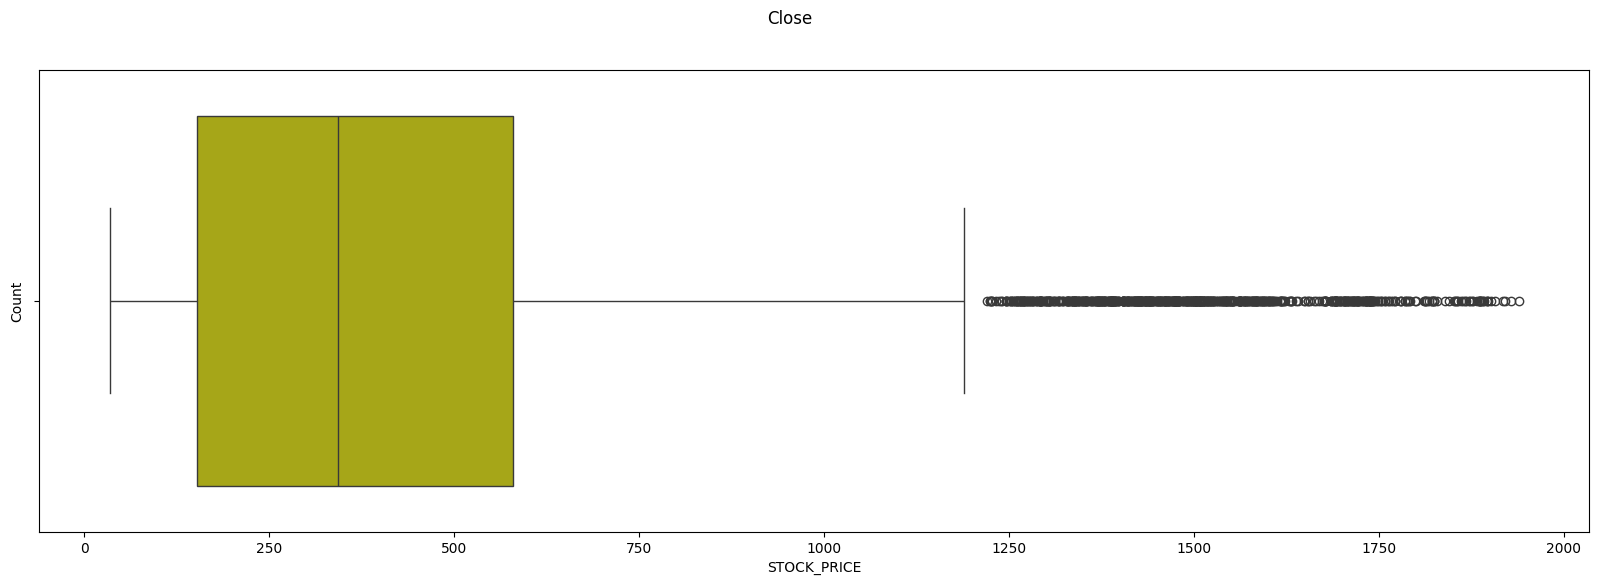

In [143]:
plt.figure(figsize=(20,6))
sns.boxplot(data=stock_data, x='STOCK_PRICE', color='#bebe00')
plt.ylabel('Count')
plt.suptitle('Close')

##### **INFERENCE** #####
1. Since the Mean is greater than the Median the data is "Positively Skewed"
2. IQR=576-151=425
3. The Median is 342
4. There are many outliers between 1250 and 2000

#### *Converting 'DATE' column to Index* ####

In [144]:
stock_data.set_index('DATE',inplace=True)

In [145]:
stock_data

,STOCK_PRICE
DATE,
03-01-2000,122.480469
04-01-2000,132.110931
05-01-2000,121.542191
06-01-2000,111.819138
07-01-2000,102.873825
...,...
04-12-2023,1464.449951
05-12-2023,1453.699951
06-12-2023,1474.099976


In [146]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5936 entries, 03-01-2000 to 08-12-2023
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STOCK_PRICE  5936 non-null   float64
dtypes: float64(1)
memory usage: 92.8+ KB


In [147]:
stock_data

,STOCK_PRICE
DATE,
03-01-2000,122.480469
04-01-2000,132.110931
05-01-2000,121.542191
06-01-2000,111.819138
07-01-2000,102.873825
...,...
04-12-2023,1464.449951
05-12-2023,1453.699951
06-12-2023,1474.099976


In [148]:
stock_data['DATE'] = stock_data.index
stock_data

,STOCK_PRICE,DATE
DATE,,
03-01-2000,122.480469,03-01-2000
04-01-2000,132.110931,04-01-2000
05-01-2000,121.542191,05-01-2000
06-01-2000,111.819138,06-01-2000
07-01-2000,102.873825,07-01-2000
...,...,...
04-12-2023,1464.449951,04-12-2023
05-12-2023,1453.699951,05-12-2023
06-12-2023,1474.099976,06-12-2023


##### **INFERENCE** #####
- As we can see here DATE is showing as 'object' i.e. a string type.
- We need to convert this to datetime format

#### *Converting 'DATE' column datetime format* ####

In [149]:
stock_data['DATE'] = pd.to_datetime(stock_data['DATE'],format='%d-%m-%Y')

In [150]:
stock_data["DATE"].info()

<class 'pandas.core.series.Series'>
Index: 5936 entries, 03-01-2000 to 08-12-2023
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
5936 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 92.8+ KB


#### **VISUALIZATIONS** ####

In [151]:
stock_data["MONTH"] = stock_data.DATE.dt.strftime("%b") # month extraction
stock_data["YEAR"] = stock_data.DATE.dt.strftime("%Y") # year extraction
stock_data["YEAR-MONTH"] = stock_data.DATE.dt.strftime("%Y-%m")
stock_data_bak = stock_data.copy()
stock_data

,STOCK_PRICE,DATE,MONTH,YEAR,YEAR-MONTH
DATE,,,,,
03-01-2000,122.480469,2000-01-03,Jan,2000,2000-01
04-01-2000,132.110931,2000-01-04,Jan,2000,2000-01
05-01-2000,121.542191,2000-01-05,Jan,2000,2000-01
06-01-2000,111.819138,2000-01-06,Jan,2000,2000-01
07-01-2000,102.873825,2000-01-07,Jan,2000,2000-01
...,...,...,...,...,...
04-12-2023,1464.449951,2023-12-04,Dec,2023,2023-12
05-12-2023,1453.699951,2023-12-05,Dec,2023,2023-12
06-12-2023,1474.099976,2023-12-06,Dec,2023,2023-12


In [152]:
def replace_outlier(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    median_val = df_in[col_name].median()
    df_out = df_in.copy()
    for i, j in df_in.iterrows():
        if (j[col_name] > upper):
            df_out.at[i, col_name] = upper
        elif (j[col_name] < lower):
            df_out.at[i, col_name] = lower
        else:
            df_out.at[i, col_name] = df_out.at[i, col_name]
    return df_out

In [153]:
def check_outliers(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    outliers = False
    for i, j in df_in.iterrows():
        if (j[col_name] > upper):
            outliers = True
        elif (j[col_name] < lower):
            outliers = True
    return outliers

In [154]:
ym_periods = stock_data['YEAR-MONTH'].unique()
ym_periods
for ym in ym_periods:
    temp_s_data = stock_data.groupby(['YEAR-MONTH']).get_group(ym)
    col_name = 'STOCK_PRICE'
    for i in range(1, 50):
        if (check_outliers(temp_s_data, col_name) == True):
            stock_data_out = replace_outlier(temp_s_data, col_name)
            stock_data_bak = stock_data_bak.set_index('DATE')
            stock_data_out = stock_data_out.set_index('DATE')
            stock_data_bak.update(stock_data_out)
            stock_data_bak.reset_index(inplace=True)

In [155]:
stock_data_bak.set_index('DATE',inplace=True)
stock_data_bak['DATE'] = pd.to_datetime(stock_data_bak.index,format='%Y-%m-%d')
stock_data_bak

,STOCK_PRICE,MONTH,YEAR,YEAR-MONTH,DATE
DATE,,,,,
2000-01-03,122.480469,Jan,2000,2000-01,2000-01-03
2000-01-04,132.110931,Jan,2000,2000-01,2000-01-04
2000-01-05,121.542191,Jan,2000,2000-01,2000-01-05
2000-01-06,111.819138,Jan,2000,2000-01,2000-01-06
2000-01-07,102.873825,Jan,2000,2000-01,2000-01-07
...,...,...,...,...,...
2023-12-04,1464.449951,Dec,2023,2023-12,2023-12-04
2023-12-05,1453.699951,Dec,2023,2023-12,2023-12-05
2023-12-06,1474.099976,Dec,2023,2023-12,2023-12-06


##### **INFERENCE** #####
**We have been able to impute the outliers using the function to substitute the outliers with the upper/lower limit values**
1. The before year graph shows the monthly outliers before imputation.
2. The after year graph shows the monthly outliers after imputation.
3. Now we see that all outliers have been fixed and don't see any outliers.

In [156]:
stock_data = stock_data_bak.copy()

In [157]:
stock_data_input = stock_data[['STOCK_PRICE']]

In [158]:
stdata = np.array(stock_data['STOCK_PRICE'])
stdata

array([ 122.480469,  132.110931,  121.542191, ..., 1474.099976,
       1466.150024, 1490.599976])

In [159]:
split_percent = 0.80
train_data, test_data = stock_data_input[:int(len(stock_data_input)*split_percent)], stock_data_input[int(len(stock_data_input)*split_percent):]


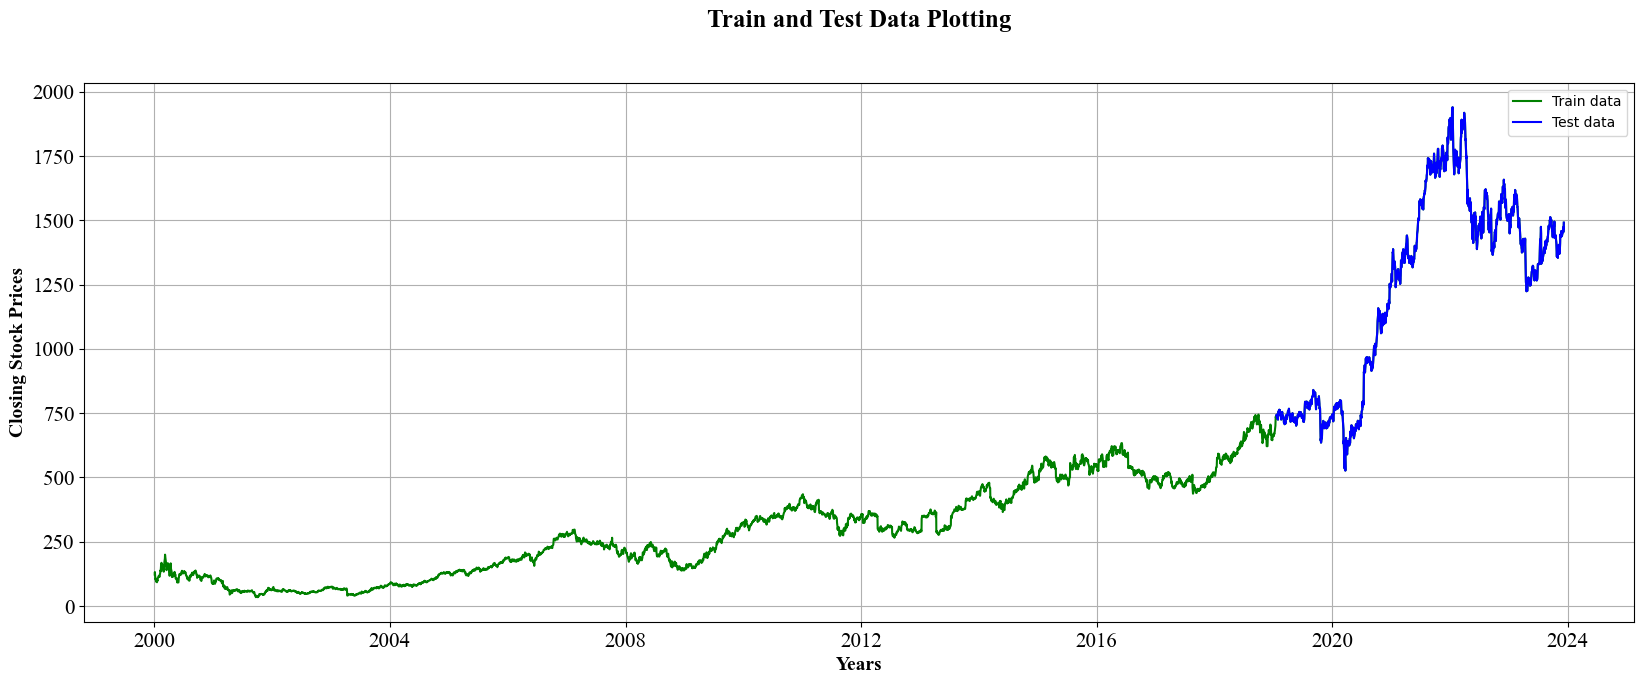

In [160]:
plt.figure(figsize=(20,7))
plt.grid(True)
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.plot(stock_data_input, color='green', label='Train data')
plt.plot(test_data, color='blue', label='Test data')
plt.title("Train and Test Data Plotting\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend()
plt.show()

In [161]:
st_data = stock_data[['STOCK_PRICE']]
st_data.reset_index()

,DATE,STOCK_PRICE
0,2000-01-03,122.480469
1,2000-01-04,132.110931
2,2000-01-05,121.542191
3,2000-01-06,111.819138
4,2000-01-07,102.873825
...,...,...
5931,2023-12-04,1464.449951
5932,2023-12-05,1453.699951
5933,2023-12-06,1474.099976
5934,2023-12-07,1466.150024


In [162]:
stocks= pd.DataFrame()
stocks['STOCK_PRICE'] = stock_data[['STOCK_PRICE']]

,STOCK_PRICE
DATE,
2000-01-03,4.807952
2000-01-04,4.883642
2000-01-05,4.800261
2000-01-06,4.716883
2000-01-07,4.633503


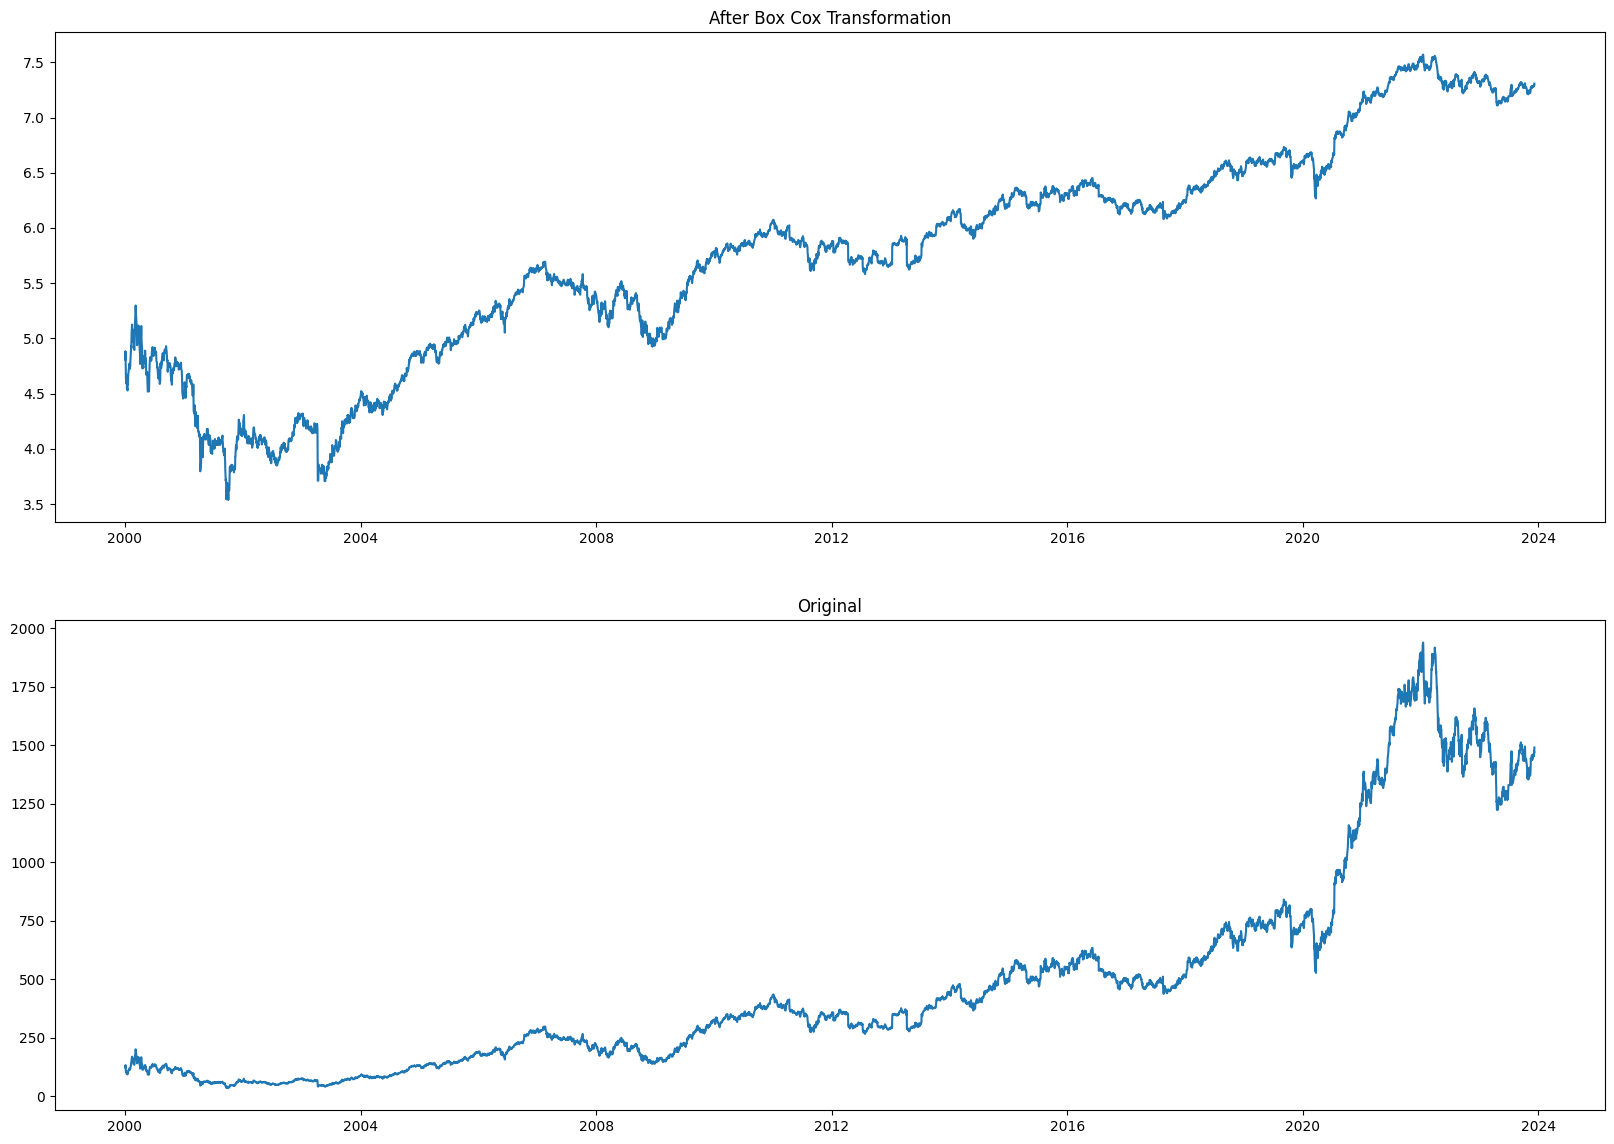

In [163]:
data_boxcox = pd.DataFrame()
data_boxcox['STOCK_PRICE'] = boxcox(stocks['STOCK_PRICE'], 0)
data_boxcox.index = stocks.index
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(20,14),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(stocks, label='original')
axis[1].set_title('Original')
plt.show()

In [164]:
from scipy.special import boxcox, inv_boxcox
df = pd.DataFrame()
df['inverse'] = inv_boxcox(data_boxcox['STOCK_PRICE'], 0)
print(df, stocks['STOCK_PRICE'])

                inverse
DATE                   
2000-01-03   122.480469
2000-01-04   132.110931
2000-01-05   121.542191
2000-01-06   111.819138
2000-01-07   102.873825
...                 ...
2023-12-04  1464.449951
2023-12-05  1453.699951
2023-12-06  1474.099976
2023-12-07  1466.150024
2023-12-08  1490.599976

[5936 rows x 1 columns] DATE
2000-01-03     122.480469
2000-01-04     132.110931
2000-01-05     121.542191
2000-01-06     111.819138
2000-01-07     102.873825
                 ...     
2023-12-04    1464.449951
2023-12-05    1453.699951
2023-12-06    1474.099976
2023-12-07    1466.150024
2023-12-08    1490.599976
Name: STOCK_PRICE, Length: 5936, dtype: float64


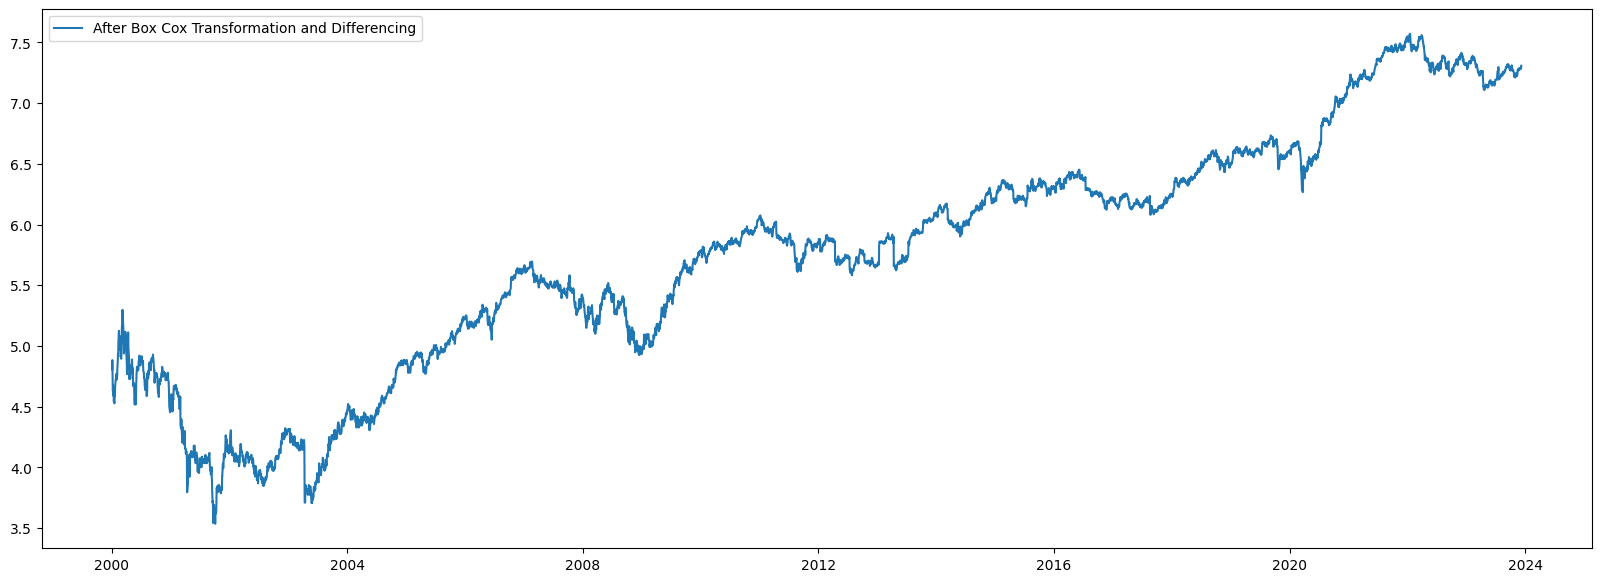

In [165]:
# Differencing of the Box-Cox Transformation
data_boxcox_diff = data_boxcox - data_boxcox.shift() # Performs difference between the previous and current observations.
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(20,7))
plt.plot(data_boxcox, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [166]:
split_percent = 0.80
train_data_boxcox, test_data_boxcox = data_boxcox[:int(len(data_boxcox)*split_percent)], data_boxcox[int(len(data_boxcox)*split_percent):]
train_data_boxcox_diff, test_data_boxcox_diff = data_boxcox_diff[:int(len(data_boxcox_diff)*split_percent)], data_boxcox_diff[int(len(data_boxcox_diff)*split_percent):]

In [167]:
sdata_bc = data_boxcox.copy()
sdata_bc.reset_index(drop=True, inplace=True)
sdata_bc['STOCK_PRICE']

0       4.807952
1       4.883642
2       4.800261
3       4.716883
4       4.633503
          ...   
5931    7.289235
5932    7.281867
5933    7.295803
5934    7.290395
5935    7.306934
Name: STOCK_PRICE, Length: 5936, dtype: float64

In [168]:
visualization_arima_bc = pd.DataFrame()
visualization_arima_bc['STOCK_PRICE'] = stock_data_input['STOCK_PRICE']
visualization_arima_bc['DIFF'] = data_boxcox['STOCK_PRICE']
visualization_arima_bc['INVERSE'] = inv_boxcox(data_boxcox['STOCK_PRICE'], 0)
visualization_arima_bc.reset_index(drop=True, inplace=True)
visualization_arima_bc
# visualization_arima_bc

,STOCK_PRICE,DIFF,INVERSE
0,122.480469,4.807952,122.480469
1,132.110931,4.883642,132.110931
2,121.542191,4.800261,121.542191
3,111.819138,4.716883,111.819138
4,102.873825,4.633503,102.873825
...,...,...,...
5931,1464.449951,7.289235,1464.449951
5932,1453.699951,7.281867,1453.699951
5933,1474.099976,7.295803,1474.099976
5934,1466.150024,7.290395,1466.150024


                               SARIMAX Results                                
Dep. Variable:            STOCK_PRICE   No. Observations:                 5936
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -22420.819
Date:                Tue, 12 Dec 2023   AIC                          44851.639
Time:                        08:42:58   BIC                          44885.083
Sample:                             0   HQIC                         44863.259
                               - 5936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        475.2031   1045.994      0.454      0.650   -1574.907    2525.313
ar.L1          0.9998      0.000   3993.372      0.000       0.999       1.000
ma.L1          0.0366      0.006      5.999      0.0

Text(0.5, 1.0, 'ARIMAX VISUALIZATION\n\n')

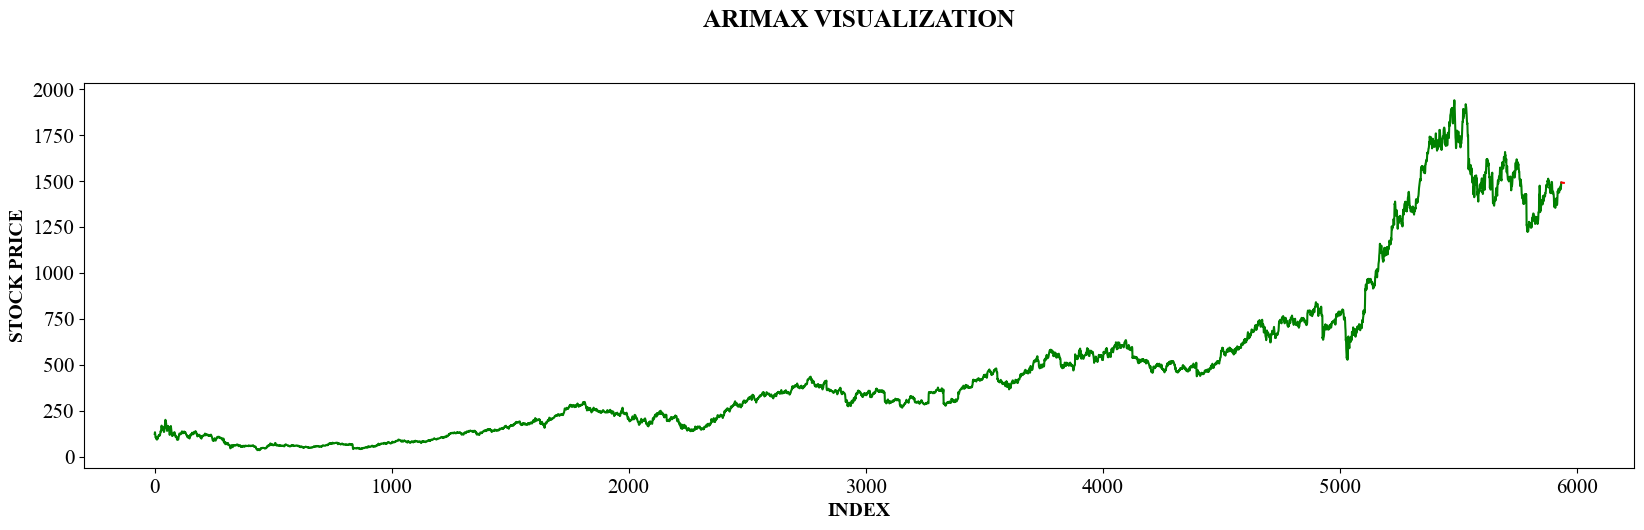

In [169]:
# stats model and arima
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 1, 0, 2
duration = 10

model_manual_calc = ARIMA(visualization_arima_bc['STOCK_PRICE'], order=(p, d, q))
model_manual_calc = model_manual_calc.fit()
print(model_manual_calc.summary())

# Predict the next 356 days below in order to see the trend. In a normal scenario, we can just take it for 15-30 days.
#forecast = model_manual_calc.predict(n_periods=30) # Alternate command for the below.
forecast = model_manual_calc.predict(len(visualization_arima_bc['STOCK_PRICE']), len(visualization_arima_bc['STOCK_PRICE'])+duration)
print(forecast)



# plot forecast
plt.figure(figsize=(20,5))
plt.plot(visualization_arima_bc['STOCK_PRICE'], 'green', label='Actual')
plt.plot(forecast, 'red', label='Forecast')
plt.xlabel('INDEX', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('STOCK PRICE', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("ARIMAX VISUALIZATION\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')


In [170]:
def get_metrics(dataset, pred):
    rmse_val = np.round(np.sqrt(mean_squared_error(dataset, pred)),2)
    mape_val = np.round(mean_absolute_percentage_error(dataset, pred)*100,2)
    return rmse_val, mape_val

In [171]:
# stats model and arima
from statsmodels.tsa.arima.model import ARIMA

split_percent = 0.80
arima_train_data, arima_test_data = data_boxcox[:int(len(data_boxcox)*split_percent)], data_boxcox[int(len(data_boxcox)*split_percent):]
p, d, q = 2, 1, 0

arima_met_model = ARIMA(arima_train_data['STOCK_PRICE'], order=(p, d, q))
arima_met_model = arima_met_model.fit()
arima_pred = arima_met_model.predict(int(len(data_boxcox)*split_percent), int(len(data_boxcox)*split_percent)+len(arima_test_data)-1)
arima_rmse, arima_mape = get_metrics(arima_test_data['STOCK_PRICE'], arima_pred)
print(f'ARIMA Model Evaluation - \nRoot Mean Squared Error (RMSE): {arima_rmse}\nMean Absolute Percent Error (MAPE): {arima_mape}\n')

ARIMA Model Evaluation - 
Root Mean Squared Error (RMSE): 0.58
Mean Absolute Percent Error (MAPE): 6.67



In [172]:
forecast

5936    1491.525888
5937    1490.894215
5938    1490.730863
5939    1490.567538
5940    1490.404239
5941    1490.240966
5942    1490.077719
5943    1489.914499
5944    1489.751305
5945    1489.588137
5946    1489.424995
Name: predicted_mean, dtype: float64

In [173]:
forecast_list = forecast.tolist()
forecast_list

[1491.5258879760327,
 1490.8942151680499,
 1490.7308634494511,
 1490.5675380024068,
 1490.404238822691,
 1490.2409659060797,
 1490.077719248349,
 1489.9144988452758,
 1489.7513046926374,
 1489.588136786212,
 1489.4249951217787]

In [174]:
import datetime
final_arima_stock_data = stock_data_input.copy()
final_arima_stock_data.reset_index(drop=True, inplace=True)
final_arima_stock_data['DATE'] = stock_data_input.index
final_arima_stock_data

,STOCK_PRICE,DATE
0,122.480469,2000-01-03
1,132.110931,2000-01-04
2,121.542191,2000-01-05
3,111.819138,2000-01-06
4,102.873825,2000-01-07
...,...,...
5931,1464.449951,2023-12-04
5932,1453.699951,2023-12-05
5933,1474.099976,2023-12-06
5934,1466.150024,2023-12-07


In [175]:
import datetime
new_forecast = pd.DataFrame(columns=final_arima_stock_data.columns)
new_forecast['STOCK_PRICE'] = forecast_list
new_forecast['Indicator'] = 'forecasted'

# Getting the last row date from 'DATE' column, which can be used to get the start_date and end_date
last_row_date = final_arima_stock_data.DATE.iloc[-1] 
last_row_date = pd.to_datetime(last_row_date, format = '%Y-%m-%d') # Last date of the data frame in formatted
start_date = last_row_date + datetime.timedelta(days=1)

# Adding duration number of days
end_date = start_date + datetime.timedelta(days=duration)

# Adding the new dates to the dataframe new_forecast
new_forecast['DATE']= pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=['DATE'])
new_forecast

,STOCK_PRICE,DATE,Indicator
0,1491.525888,2023-12-09,forecasted
1,1490.894215,2023-12-10,forecasted
2,1490.730863,2023-12-11,forecasted
3,1490.567538,2023-12-12,forecasted
4,1490.404239,2023-12-13,forecasted
5,1490.240966,2023-12-14,forecasted
6,1490.077719,2023-12-15,forecasted
7,1489.914499,2023-12-16,forecasted
8,1489.751305,2023-12-17,forecasted
9,1489.588137,2023-12-18,forecasted


In [176]:
final_arima_stock_data = pd.concat([final_arima_stock_data, new_forecast], ignore_index=True)
final_arima_stock_data.set_index('DATE',inplace=True)

In [177]:
final_arima_stock_data[['Indicator']] = final_arima_stock_data[['Indicator']].fillna('orig')
final_arima_stock_data

,STOCK_PRICE,Indicator
DATE,,
2000-01-03,122.480469,orig
2000-01-04,132.110931,orig
2000-01-05,121.542191,orig
2000-01-06,111.819138,orig
2000-01-07,102.873825,orig
...,...,...
2023-12-15,1490.077719,forecasted
2023-12-16,1489.914499,forecasted
2023-12-17,1489.751305,forecasted


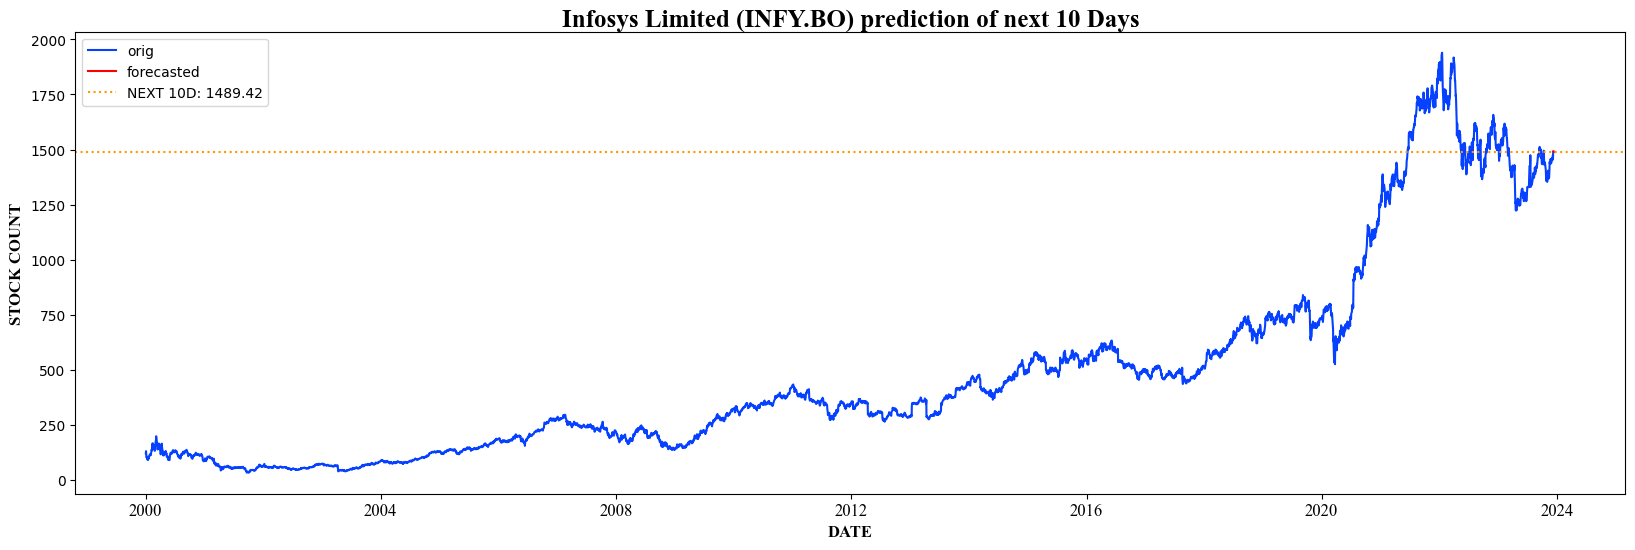

In [178]:
# The yahoo finance ticker for the stock symbol for Infosys
stock_symbol = "Infosys Limited (INFY.BO)"

plt.figure(figsize=(20,6))
sns.lineplot(x='DATE', y='STOCK_PRICE', hue='Indicator', palette=['#0541ff','#FF0000'], data=final_arima_stock_data)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title(f"{stock_symbol} prediction of next {duration} Days", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.axhline(y=final_arima_stock_data.STOCK_PRICE[len(final_arima_stock_data)-1], color = '#ff9900', linestyle = ':', label = f'NEXT {duration}D: {round(float(final_arima_stock_data.STOCK_PRICE[len(final_arima_stock_data)-1]),2)}')
plt.legend()
plt.show()

In [179]:
import pickle
pickle.dump(model_manual_calc, open('arima_model.pkl', 'wb'))

In [180]:
pickled_arima_model = pickle.load(open('arima_model.pkl', 'rb'))
# pickled_model.predict(int(len(data_boxcox)*split_percent), int(len(data_boxcox)*split_percent)+len(arima_test_data)-1)
pickled_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            STOCK_PRICE   No. Observations:                 5936
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -22420.819
Date:                Tue, 12 Dec 2023   AIC                          44851.639
Time:                        08:42:59   BIC                          44885.083
Sample:                             0   HQIC                         44863.259
                               - 5936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        475.2031   1045.994      0.454      0.650   -1574.907    2525.313
ar.L1          0.9998      0.000   3993.372      0.000       0.999       1.000
ma.L1          0.0366      0.006      5.999      0.000       0.025       0.049
ma.L2         -0.0185      0.006     -3.059      0.002      -0.030      -0.007
sigma2       111.5978      0.605    184.502      0.000     110.412     112.783
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            124921.14
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              25.72   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""